In [2]:
!pip install transformers torch


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [3]:
import pandas as pd
import re
import torch
from sklearn.model_selection import train_test_split
from transformers import AutoModelForSequenceClassification, AutoTokenizer, pipeline, BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import nltk
from nltk.corpus import stopwords

# Ensure NLTK stopwords are downloaded
nltk.download('stopwords')

# Step 1: Preprocess Dataset
def preprocess_dataset(file_path, encoding='utf-8-sig'):
    df = pd.read_csv(file_path, encoding=encoding)

    def preprocess_text(text):
        if not isinstance(text, str):
            text = str(text)
        text = re.sub(r'[^\u0980-\u09FF\s]', '', text)  # Remove non-Bangla characters
        text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
        return text

    df['cleaned_comment'] = df['text'].apply(preprocess_text)

    def is_bangla(text):
        return bool(re.search('[\u0980-\u09FF]', str(text)))

    df_bangla = df[df['cleaned_comment'].apply(is_bangla)]

    return df_bangla

file_path = '/kaggle/input/fackbook-comments-dataset/Final Total Datasets.csv'
df_bangla = preprocess_dataset(file_path)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/tmp/ipykernel_34/2885290118.py:14: DtypeWarning: Columns (16,17,18,19,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, encoding=encoding)


In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df_bangla['cleaned_comment'])

# Perform K-means clustering
kmeans = KMeans(n_clusters=2, random_state=0)
df_bangla['cluster'] = kmeans.fit_predict(X)

# Assume cluster 0 is negative and cluster 1 is positive (this might need manual checking)
df_bangla['label'] = df_bangla['cluster'].apply(lambda x: 'NEGATIVE' if x == 0 else 'POSITIVE')
print(' Positive Comments: ',df_bangla[df_bangla['label'] == 'POSITIVE'].shape[0])
print(' Negative Comments: ',df_bangla[df_bangla['label'] == 'NEGATIVE'].shape[0])

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


 Positive Comments:  5731
 Negative Comments:  86855


In [5]:
print(df_bangla.head())

                                         facebookUrl  \
0  https://www.facebook.com/watch?v=1103256504442984   
1  https://www.facebook.com/watch?v=1103256504442984   
3  https://www.facebook.com/watch?v=1103256504442984   
4  https://www.facebook.com/watch?v=1103256504442984   
6  https://www.facebook.com/watch?v=1103256504442984   

                                          commentUrl  \
0  https://www.facebook.com/watch?v=1103256504442...   
1  https://www.facebook.com/watch?v=1103256504442...   
3  https://www.facebook.com/watch?v=1103256504442...   
4  https://www.facebook.com/watch?v=1103256504442...   
6  https://www.facebook.com/watch?v=1103256504442...   

                                                  id  \
0  Y29tbWVudDozNjM2NDAzNzk2MjU1NjFfOTIzMTgxOTEyNj...   
1  Y29tbWVudDozNjM2NDAzNzk2MjU1NjFfMzEwMzc0NzgxOT...   
3  Y29tbWVudDozNjM2NDAzNzk2MjU1NjFfMTgxMjU4MTc4NT...   
4  Y29tbWVudDozNjM2NDAzNzk2MjU1NjFfODI3MTI5MzY5Mj...   
6  Y29tbWVudDozNjM2NDAzNzk2MjU1NjFfMjQ2NDM1Njk

In [6]:
# Step 3: Split the Data
train_texts, val_texts, train_labels, val_labels = train_test_split(df_bangla['cleaned_comment'], df_bangla['cluster'], test_size=0.2, random_state=42)


Training set class distribution:
cluster
0    69512
1     4556
Name: count, dtype: int64

Validation set class distribution:
cluster
0    17343
1     1175
Name: count, dtype: int64


/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


vocab.txt:   0%|          | 0.00/2.24M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/491 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/660M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sagorsarker/bangla-bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Mcc
1,0.033700,0.043993,0.992062,0.940988,0.890578,0.997447,0.938476
2,0.061900,0.023995,0.995194,0.963299,0.934400,0.994043,0.961257
3,0.000700,0.022209,0.995518,0.965688,0.938907,0.994043,0.963742
4,0.000000,0.023287,0.995680,0.966942,0.939759,0.995745,0.965095
5,0.000200,0.020583,0.995896,0.968491,0.944220,0.994043,0.966663
6,0.000100,0.035792,0.994438,0.957804,0.923381,0.994894,0.955592
7,0.000100,0.025074,0.995626,0.966515,0.939711,0.994894,0.964626
8,0.030800,0.021211,0.996490,0.972701,0.960199,0.985532,0.970919
9,0.045600,0.021171,0.996382,0.972025,0.954098,0.990638,0.970287
10,0.000000,0.026539,0.996058,0.969621,0.948697,0.991489,0.967784


Validation results: {'eval_loss': 0.021211393177509308, 'eval_accuracy': 0.996489901717248, 'eval_f1': 0.9727005459890803, 'eval_precision': 0.9601990049751243, 'eval_recall': 0.985531914893617, 'eval_mcc': 0.9709192452694264, 'eval_runtime': 78.6863, 'eval_samples_per_second': 235.34, 'eval_steps_per_second': 14.717, 'epoch': 13.0}


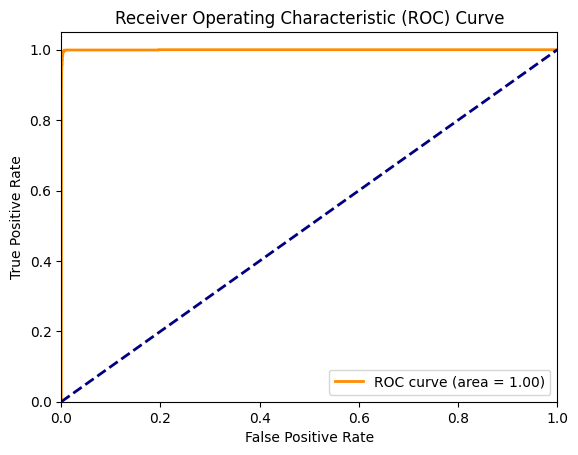

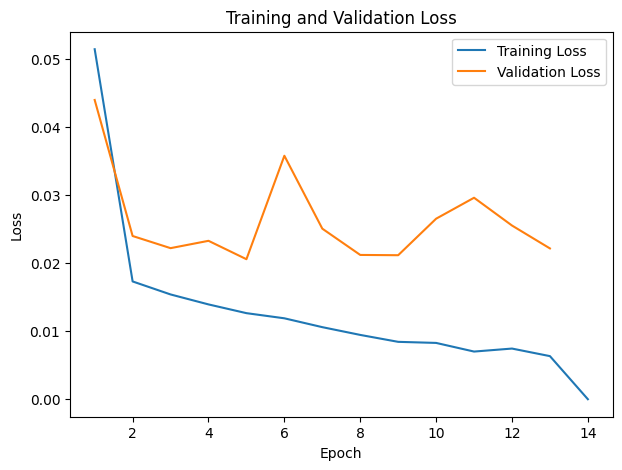

In [7]:
import torch
from torch.utils.data import Dataset
from transformers import BertTokenizer, BertForSequenceClassification, TrainingArguments, Trainer
from transformers import EarlyStoppingCallback
import numpy as np
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, matthews_corrcoef, roc_curve, auc
import pandas as pd
import matplotlib.pyplot as plt
import os

# Assuming df_bangla is already defined and contains the 'cleaned_comment' and 'label' columns
# Step 3: Split the Data
train_texts, val_texts, train_labels, val_labels = train_test_split(df_bangla['cleaned_comment'], df_bangla['cluster'], test_size=0.2, random_state=42)

# Debugging: Print class distribution
print("Training set class distribution:")
print(train_labels.value_counts())
print("\nValidation set class distribution:")
print(val_labels.value_counts())

# Define a custom dataset class
class ReviewsDataset(Dataset):
    def __init__(self, reviews, labels, tokenizer, max_len):
        self.reviews = reviews
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, item):
        review = str(self.reviews.iloc[item])
        label = self.labels.iloc[item]
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Check if GPU is available and set the device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=20,              
    per_device_train_batch_size=16,   
    per_device_eval_batch_size=16,    
    warmup_steps=500,                
    weight_decay=0.05,               
    logging_dir='./logs',            
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,  # Load the best model at the end
    metric_for_best_model="accuracy",  # Use accuracy to determine the best model
    greater_is_better=True,
    learning_rate=2e-6,
    save_total_limit=2,
)

# Define a function to compute additional metrics
def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    labels = p.label_ids
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary', zero_division=1)
    mcc = matthews_corrcoef(labels, preds)
    accuracy = accuracy_score(labels, preds)
    return {
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'mcc': mcc
    }

# Load the pre-trained BanglaBERT tokenizer
tokenizer = BertTokenizer.from_pretrained('sagorsarker/bangla-bert-base')

# Prepare the datasets
train_dataset = ReviewsDataset(train_texts, train_labels, tokenizer, max_len=128)
val_dataset = ReviewsDataset(val_texts, val_labels, tokenizer, max_len=128)

# Load the pre-trained BanglaBERT model
model = BertForSequenceClassification.from_pretrained('sagorsarker/bangla-bert-base', hidden_dropout_prob=0.3, attention_probs_dropout_prob=0.3)
model.to(device)  # Move the model to the appropriate device (GPU or CPU)

# Initialize the Trainer with early stopping callback
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]  # Early stopping after 3 epochs of no improvement
)

# Train the model
trainer.train()

# Evaluate the model
results = trainer.evaluate()
print(f"Validation results: {results}")

# Calculate ROC curve and AUC for the validation set
predictions = trainer.predict(val_dataset)
probs = torch.softmax(torch.tensor(predictions.predictions), dim=1).numpy()[:, 1]
fpr, tpr, _ = roc_curve(predictions.label_ids, probs)
roc_auc = auc(fpr, tpr)

# Show ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Extract and average loss values per epoch
epoch_train_loss = {}
epoch_val_loss = {}
for log in trainer.state.log_history:
    if 'loss' in log and 'epoch' in log:
        epoch = int(log['epoch'])
        if epoch not in epoch_train_loss:
            epoch_train_loss[epoch] = []
        epoch_train_loss[epoch].append(log['loss'])
    if 'eval_loss' in log and 'epoch' in log:
        epoch = int(log['epoch'])
        if epoch not in epoch_val_loss:
            epoch_val_loss[epoch] = []
        epoch_val_loss[epoch].append(log['eval_loss'])

# Calculate average loss per epoch
train_loss_avg = [np.mean(losses) for epoch, losses in sorted(epoch_train_loss.items())]
val_loss_avg = [np.mean(losses) for epoch, losses in sorted(epoch_val_loss.items())]

# Plot training and validation loss
plt.figure(figsize=(7, 5))
plt.plot(range(1, len(train_loss_avg) + 1), train_loss_avg, label='Training Loss')
plt.plot(range(1, len(val_loss_avg) + 1), val_loss_avg, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
#5e80cc417a430ca1d269eec205baf2b5a096a2b6